# Prerequisites

- Make sure to use a pythen environment > V.3.11 

- In terminal, run 
```bash
pip install -r /mikael/requirements.txt
```


In [1]:
from Master import MasterDataframes
from feature_engine.timeseries.forecasting import LagFeatures


# Data handling
import pickle
import pandas as pd

# Helper functions
from functions import get_days_sinse_beginning_of_year, get_seconds_of_day

# Types handling
import numpy as np
from fractions import Fraction

# Data science
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

# Machine learning tool
import xgboost as xgb
# Optimization / feature engineering tools
import optuna

# Plotting
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Smart options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Looking at the target

In [2]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

In [3]:
test_df = pd.read_csv("../test.csv")

In [4]:
test_df.head()

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A


<Axes: title={'center': 'target  C'}, xlabel='time'>

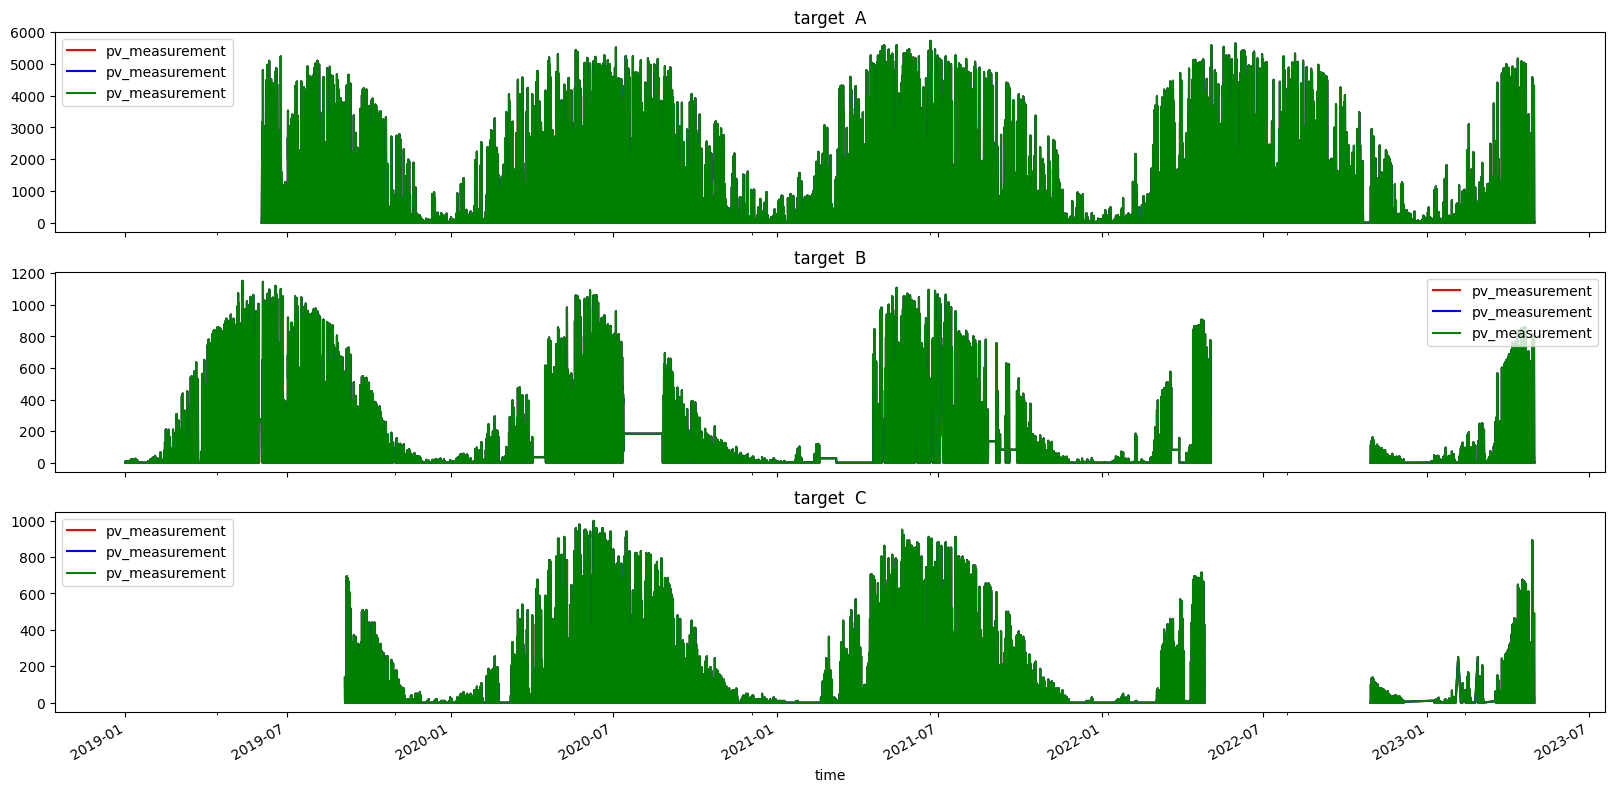

In [5]:
# Plotting a single feature
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'pv_measurement'
train_a[['time', feature_name]].set_index('time').plot(ax=axs[0], title='target A', color='red')
train_a[['time', feature_name]].set_index('time').plot(ax=axs[0], title='target A', color='blue')
train_a[['time', feature_name]].set_index('time').plot(ax=axs[0], title='target  A', color='green')

train_b[['time', feature_name]].set_index('time').plot(ax=axs[1], title='target  B', color='red')
train_b[['time', feature_name]].set_index('time').plot(ax=axs[1], title='target  B', color='blue')
train_b[['time', feature_name]].set_index('time').plot(ax=axs[1], title='target  B', color='green')

train_c[['time', feature_name]].set_index('time').plot(ax=axs[2], title='target  C', color='red')
train_c[['time', feature_name]].set_index('time').plot(ax=axs[2], title='target  C', color='blue')
train_c[['time', feature_name]].set_index('time').plot(ax=axs[2], title='target  C', color='green')

# Looking at A, B, C features

In [6]:
# Estimate
X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

# Test estimates
X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

# Observations
X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

# Targets
Y_train_observed_a = pd.read_parquet('../A/train_targets.parquet')
Y_train_observed_b = pd.read_parquet('../B/train_targets.parquet')
Y_train_observed_c = pd.read_parquet('../C/train_targets.parquet')


In [7]:
X_test_estimated_a

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.4,1.286,912.700012,0.0,0.0,1041.199951,0.0,271.700012,0.0,0.0,0.0,0.0,80.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.0,0.0,1000.700012,1007.000000,0.0,0.0,80.300003,1013.299988,NaN,0.0,0.0,0.0,0.0,10.520000,-11.185,0.0,273.799988,80.699997,30210.699219,4.0,2.2,3.4,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.3,1.287,912.700012,0.0,0.0,1054.800049,0.0,271.700012,0.0,0.0,0.0,0.0,77.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.700012,0.0,0.0,1000.599976,1006.900024,0.0,0.0,80.300003,1013.200012,NaN,0.0,0.0,0.0,0.0,14.203000,-10.825,0.0,273.799988,77.000000,30003.599609,4.0,2.1,3.4,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.3,1.287,912.700012,0.0,0.0,1068.300049,0.0,271.600006,0.0,0.0,0.0,0.0,73.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.599976,0.0,0.0,1000.500000,1006.700012,0.0,0.0,80.300003,1013.000000,NaN,0.0,0.0,0.0,0.0,17.868999,-10.360,0.0,273.799988,73.099998,29797.099609,3.9,2.1,3.3,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.3,1.287,912.700012,0.0,0.0,1081.900024,0.0,271.600006,0.0,0.0,0.0,0.0,69.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.500000,0.0,0.0,1000.400024,1006.599976,0.0,0.0,80.199997,1012.900024,NaN,0.0,0.0,0.0,0.0,21.514000,-9.794,0.0,273.799988,69.000000,29618.599609,3.9,2.0,3.3,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.3,1.287,NaN,0.0,0.0,1095.400024,0.0,271.600006,0.0,0.0,0.0,0.0,64.500000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.299988,0.0,0.0,1000.200012,1006.500000,0.0,0.0,80.199997,1012.799988,NaN,0.0,0.0,0.0,0.0,25.135000,-9.128,0.0,273.799988,64.500000,29507.500000,3.9,2.0,3.3,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2023-07-02 07:00:31,2023-07-03 22:45:00,9.1,1.207,2090.600098,0.0,0.0,1629.400024,0.0,282.700012,0.0,0.0,0.0,0.0,99.300003,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.299988,0.0,0.0,980.799988,986.700012,0.0,0.0,82.199997,992.599976,NaN,0.0,0.0,-0.0,0.0,351.855988,-3.282,0.1,285.399994,99.400002,39931.601562,2.1,1.7,-1.3,0.0
2876,2023-07-02 07:00:31,2023-07-03 23:00:00,9.1,1.207,2015.800049,0.0,0.0,1537.300049,0.0,282.700012,0.0,0.0,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.400024,0.0,0.0,980.900024,986.799988,0.0,0.0,82.500000,992.700012,NaN,0.0,0.0,-0.0,0.0,355.317993,-3.469,0.1,285.299988,100.000000,39574.300781,2.0,1.6,-1.3,0.0
2877,2023-07-02 07:00:31,2023-07-03 23:15:00,9.1,1.208,2015.699951,0.0,0.0,1471.400024,0.0,282.700012,0.0,0.0,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.500000,0.0,0.0,981.000000,986.900024,0.0,0.0,82.800003,992.799988,NaN,0.0,0.0,-0.0,0.0,358.785004,-3.556,0.1,285.299988,100.000000,39627.199219,2.0,1.6,-1.2,0.0
2878,2023-07-02 07:00:31,2023-07-03 23:30:00,9.0,1.208,2015.599976,0.0,0.0,1405.500000,0.0,282.700012,0.0,0.0,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.599976,0.0,0.0,981.000000,986.900024,0.0,0.0,83.199997,992.900024,NaN,0.0,0.0,-0.0,0.0,2.253000,-3.541,0.1,285.200012,100.000000,39691.800781,2.0,1.6,-1.1,0.0


In [8]:
tests = [X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]

rows = 0

for i, X_test in enumerate(tests):
    mapping = ["A", "B", "C"]
    
    X_test_group = X_test.groupby(pd.Grouper(key='date_forecast', freq='1H')).mean().reset_index()
    
    X_test_group["time_merge"] = pd.to_datetime(X_test_group["date_forecast"])
    test_df["time_merge"] = pd.to_datetime(test_df["time"])
    test_mapped = test_df.loc[test_df["location"] == mapping[i]]
    merged = X_test_group.merge(test_mapped[["time", "time_merge"]], how="inner", on="time_merge")
    merged.drop(columns=["time", "time_merge"], axis=1, inplace=True)
    rows += merged["date_forecast"].count()
    # merged.to_parquet(f"../{mapping[i]}/X_test_{mapping[i]}.parquet")
    
rows

2160

<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

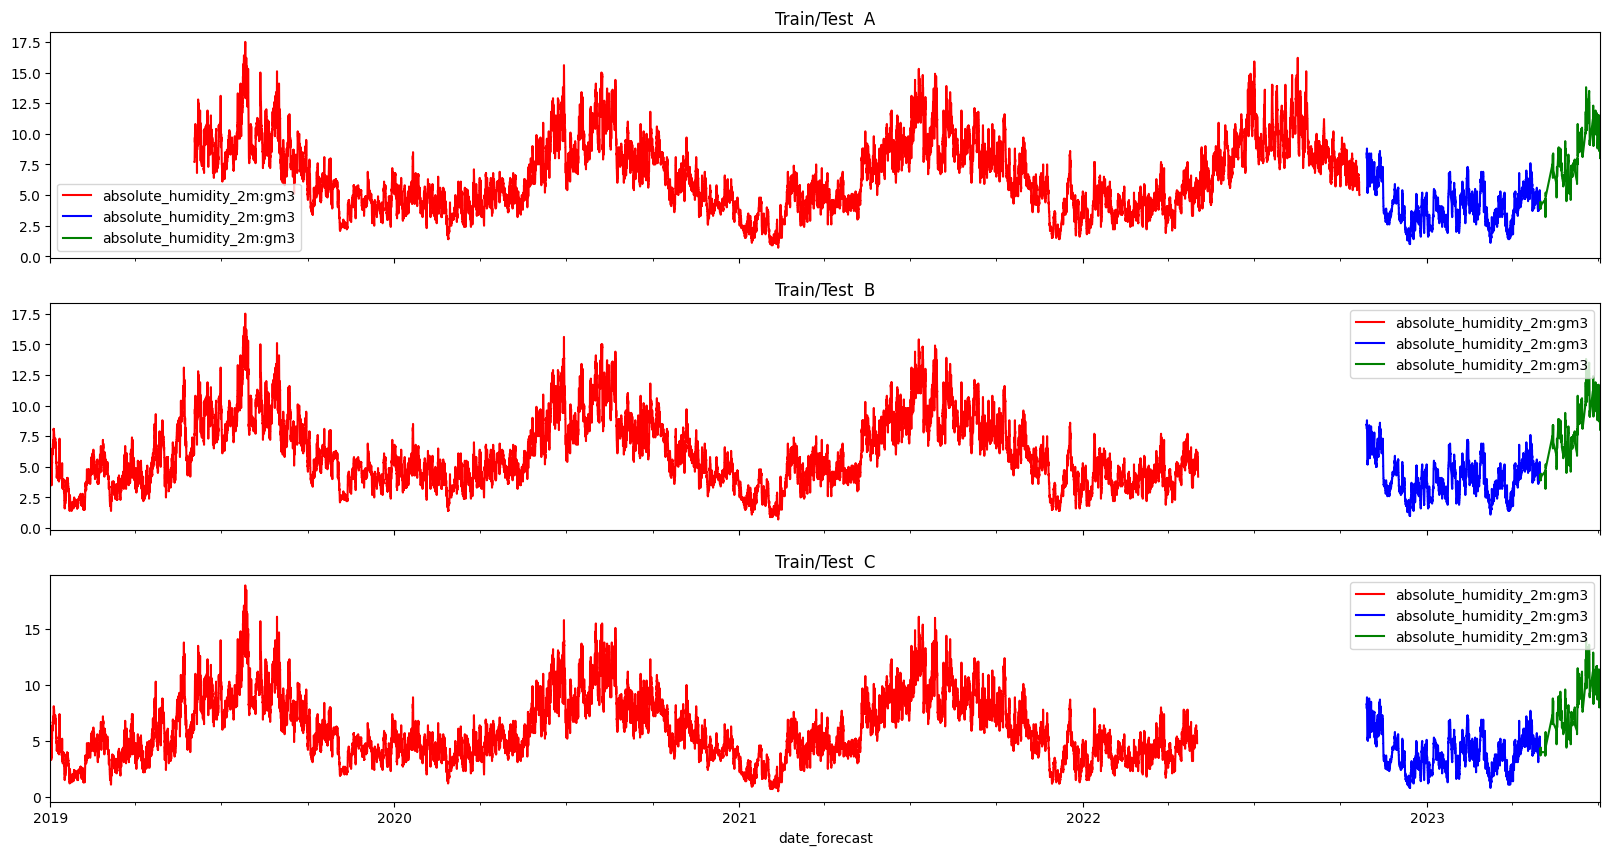

In [9]:
# Plotting a single feature
feature_name = 'absolute_humidity_2m:gm3'

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

# Creating the dataset

NB: Looking mainly at "A"

1. Group the data by whole hours on row mean
2. Merge train and target (simplify feature engineering)

In [10]:
X_train_group_b = X_train_observed_b.groupby(pd.Grouper(key='date_forecast', freq='1H')).mean().reset_index()
X_train_group_b.rename(columns={"date_forecast":"time"}, inplace=True)

inner_merge = pd.merge(X_train_group_b, Y_train_observed_b, on="time", how="inner")
id_columns = [c for c in inner_merge.columns if ":idx" in c]
id_columns

['dew_or_rime:idx',
 'is_day:idx',
 'is_in_shadow:idx',
 'precip_type_5min:idx',
 'snow_drift:idx']

# Target encoding and features

The ":idx" columns are categorical values sampled from [0, 0.25, 0.5, 0.75, 1]

What target encoding does:
- maps the categorical value to the target value at this time

In [11]:
target = ['pv_measurement']
target_encode_df = inner_merge[id_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in id_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = inner_merge.drop(id_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_target = pd.concat([score_target_drop, target_df], axis = 1)


# Features
score_target["year"] = inner_merge["time"].apply(lambda datestring: np.datetime64(datestring).astype(pd.Timestamp).year)
score_target["month"] = inner_merge["time"].apply(lambda datestring: np.datetime64(datestring).astype(pd.Timestamp).month)
score_target["seconds_in_day"] = inner_merge["time"].apply(lambda datestring: get_seconds_of_day(datestring))
score_target["days_sinse_jan_1"] = inner_merge["time"].apply(lambda datestring: get_days_sinse_beginning_of_year(datestring))



In [12]:
score_target["total_cloud_cover:p"]

0        86.324997
1        99.074997
2        97.925003
3        97.224998
4        96.824997
           ...    
29217    61.500000
29218    37.275002
29219    35.125000
29220    41.549999
29221    48.924999
Name: total_cloud_cover:p, Length: 29222, dtype: float32

In [13]:
score_target[id_columns]

,dew_or_rime:idx,is_day:idx,is_in_shadow:idx,precip_type_5min:idx,snow_drift:idx
0,103.860871,8.297741,8.384795,44.819453,102.595696
1,103.860871,8.297741,8.384795,83.205700,102.595696
2,103.860871,8.297741,8.384795,107.792116,102.595696
3,103.860871,8.297741,8.384795,44.819453,102.595696
4,103.860871,8.297741,8.384795,83.205700,102.595696
...,...,...,...,...,...
29217,103.860871,14.483375,20.855421,53.917549,102.595696
29218,103.860871,8.297741,8.384795,107.792116,102.595696
29219,103.860871,8.297741,8.384795,107.792116,102.595696
29220,103.860871,8.297741,8.384795,107.792116,102.595696


In [14]:
c = [c for c in score_target.columns if "cloud" in c]
c

['cloud_base_agl:m', 'effective_cloud_cover:p', 'total_cloud_cover:p']

# Cleaning

In [15]:
inner_to_split = score_target.copy().drop(columns=[c for c in score_target.columns if "date" in c or "time" in c])
non_id_columns = [c for c in inner_to_split.columns if ":idx" not in c]

inner_to_split[id_columns].fillna(0, inplace=True)
inner_to_split[non_id_columns].fillna(inner_to_split.mean(), inplace=True)

inner_to_split = inner_to_split.astype("float")

X = inner_to_split.drop(columns=["pv_measurement"])
Y = inner_to_split["pv_measurement"]
inner_to_split.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,msl_pressure:hPa,precip_5min:mm,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement,dew_or_rime:idx,is_day:idx,is_in_shadow:idx,precip_type_5min:idx,snow_drift:idx,year,month,seconds_in_day,days_sinse_jan_1
count,29222.000000,29222.000000,24823.000000,2.922200e+04,29222.000000,27477.000000,29222.000000,29222.000000,2.922200e+04,29222.000000,2.922200e+04,29222.000000,29222.0,29222.000000,29222.000000,29222.00000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,1444.0,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29218.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000,29222.000000
mean,6.126064,1.254257,2671.760584,5.423416e+05,150.650417,1741.069169,275.525447,40.908794,1.472716e+05,53.388559,1.921992e+05,66.771972,7.0,0.072151,0.006007,0.14439,0.018041,0.036076,1009.400560,0.005571,996.366913,1002.493280,0.056856,0.009639,73.439568,1008.646920,250.0,0.340993,0.000273,0.090115,179.620891,-0.311926,0.059317,279.631541,73.499162,33040.418138,3.122037,0.751164,0.548478,0.000027,102.585162,102.581374,102.572256,102.572268,102.581876,102.585163,2020.200329,6.122784,41405.666963,169.965061
std,2.727357,0.035278,2408.282920,8.381458e+05,233.412098,1728.126147,6.772917,61.288284,2.180486e+05,116.488991,4.140295e+05,33.880674,0.0,0.541348,0.069708,0.91209,0.181551,0.317495,12.949023,0.028977,12.835631,12.890140,1.172967,0.040830,14.299230,12.946648,0.0,1.919457,0.004678,0.238586,97.556055,24.016511,0.107520,6.633595,33.566421,17888.357556,1.821521,2.941663,1.872937,0.001491,198.993595,10.004228,100.479025,106.797954,18.121912,1.039489,0.979746,3.502493,24912.791641,107.082629
min,0.700000,1.151500,27.849998,0.000000e+00,0.000000,27.975000,251.050003,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,7.0,0.000000,0.000000,0.00000,0.000000,0.000000,944.500000,0.000000,932.299988,938.049988,0.000000,0.000000,19.575001,943.849976,250.0,0.000000,0.000000,0.000000,6.983750,-49.893250,0.000000,259.024994,0.000000,174.725006,0.050000,-7.225000,-8.400000,0.000000,0.000000,1.940625,8.297741,8.384795,0.000000,0.000000,2019.000000,1.000000,0.000000,0.000000
25%,4.125000,1.230000,1052.087524,0.000000e+00,0.000000,654.075012,271.100006,0.000000,0.000000e+00,0.000000,0.000000e+00,41.825001,7.0,0.000000,0.000000,0.00000,0.000000,0.000000,1001.575012,0.000000,988.599976,994.674988,0.000000,0.000000,64.150002,1000.825012,250.0,0.000000,0.000000,0.000000,94.243816,-17.376874,0.000000,275.049988,53.150002,16880.900391,1.700000,-1.450000,-0.700000,0.000000,0.000000,103.860871,8.297741,8.384795,107.792116,102.595696,2019.000000,3.000000,21600.000000,76.000000
50%,5.550000,1.253750,1746.949951,1.832788e+04,3.100000,1230.199951,275.250000,1.700000,1.492103e+04,0.000000,1.377125e+02,78.762501,7.0,0.000000,0.000000,0.00000,0.000000,0.000000,1010.224976,0.000000,997.224976,1003.325012,0.000000,0.000000,75.949997,1009.450012,250.0,0.000000,0.000000,0.000000,180.006378,-0.223125,0.000000,278.799988,91.925003,37467.449219,2.775000,0.400000,0.575000,0.000000,0.000000,103.860871,16.034064,8.384795,107.792116,102.595696,2020.000000,6.000000,43200.000000,162.000000
75%,7.950

In [19]:
for c in X.columns:
    print(X[X[c].isna()].index)

Index([], dtype='int64')
Index([], dtype='int64')
Index([  588,   589,   590,   591,   592,   593,   594,   595,   596,   603,
       ...
       29118, 29119, 29120, 29148, 29149, 29213, 29218, 29219, 29220, 29221],
      dtype='int64', length=4399)
Index([], dtype='int64')
Index([], dtype='int64')
Index([  588,   589,   590,   591,   592,   593,   594,   595,   596,   603,
       ...
       28998, 28999, 29000, 29001, 29002, 29008, 29009, 29010, 29011, 29016],
      dtype='int64', length=1745)
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')


In [24]:
no_nan_columns_df = X[[c for c in X.columns if len(X[X[c].isna()].index) == 0]]

no_nan_columns = no_nan_columns_df.columns.to_list()

lag_f = LagFeatures(variables = no_nan_columns, periods=1)

X_tr = lag_f.fit_transform(no_nan_columns_df)

X[X_tr.columns] = X_tr

In [ ]:
inner_merge.to_csv("pv_forecasting.csv")

# Correlations

<Axes: >

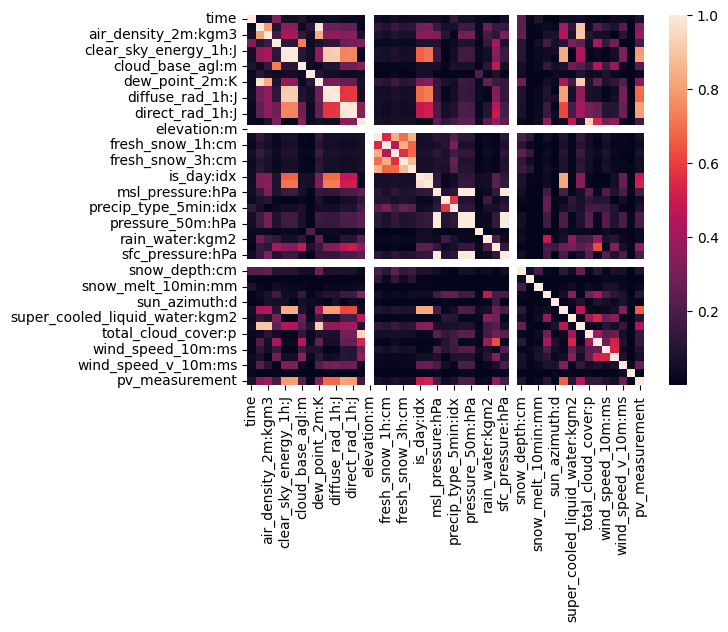

In [ ]:
sns.heatmap(np.abs(inner_merge.corr( )))

# Simple Linear Model

In [ ]:
best_correlations = inner_merge.corr()[np.abs(inner_merge.corr()) > 0.5]["pv_measurement"].dropna()

In [ ]:
features = list(best_correlations.index)
features.remove("pv_measurement")

<Axes: xlabel='clear_sky_energy_1h:J', ylabel='pv_measurement'>

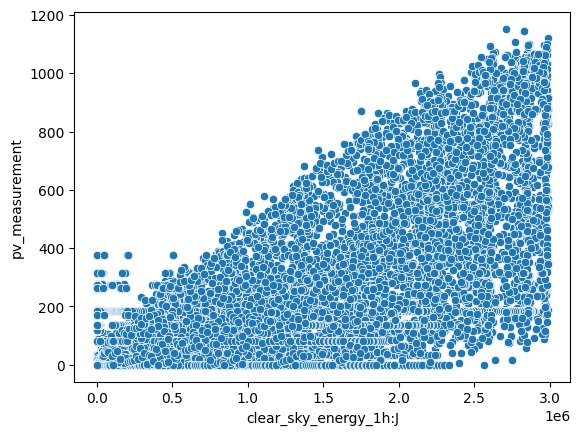

In [ ]:
sns.scatterplot(inner_merge, x='clear_sky_energy_1h:J', y="pv_measurement")

<Axes: xlabel='sun_azimuth:d', ylabel='pv_measurement'>

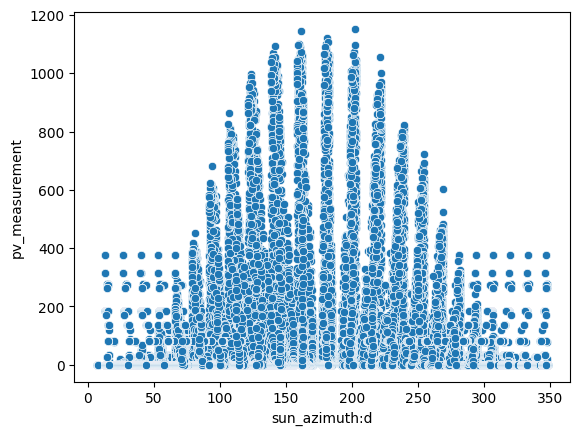

In [ ]:
sns.scatterplot(inner_merge, x='sun_azimuth:d', y="pv_measurement")

In [ ]:
X = inner_merge[features].dropna()
Y = inner_merge["pv_measurement"].dropna() 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

ValueError: Found input variables with inconsistent numbers of samples: [29222, 29218]

In [ ]:
model = LinearRegression().fit(X_train, y_train)

In [ ]:
model.score(X_test, y_test)

-0.35134205532216956

In [ ]:
Mas